In [1]:
import numpy as np
import qiskit.pulse as pulse
from qiskit_ibm_provider import IBMProvider

from casq.gates import GaussianPulseGate
from casq.common import plot, plot_bloch, plot_signal, LineStyle, LineType, LineConfig, LegendStyle
from casq import PulseSolver

%matplotlib inline


In [2]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
from qiskit_dynamics.array import Array
Array.set_default_backend("jax")


In [3]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_manila")
config = backend.configuration()
properties = backend.properties()
solver = PulseSolver.from_backend("ibmq_manila", qubits=[0])


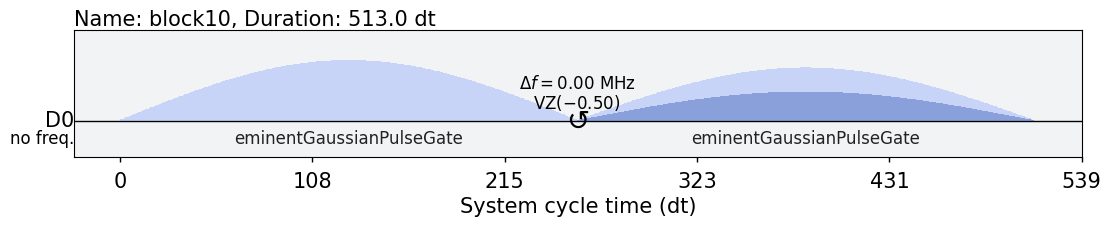

In [4]:
dt = config.dt
qubit = 0
qubit_frequency = properties.frequency(qubit)
duration = 256
sigma = 128

schedules = []

for amplitude in np.linspace(0., 1., 10):
    gpg = GaussianPulseGate(duration, amplitude, sigma)
    with pulse.build() as schedule:
        with pulse.align_sequential():
            gpg.instruction(qubit)
            pulse.shift_phase(0.5, pulse.DriveChannel(qubit))
            pulse.shift_frequency(0.1, pulse.DriveChannel(qubit))
            gpg.instruction(qubit)
            pulse.acquire(duration=1, qubit_or_channel=qubit, register=pulse.MemorySlot(qubit))

    schedules.append(schedule)

schedules[5].draw()


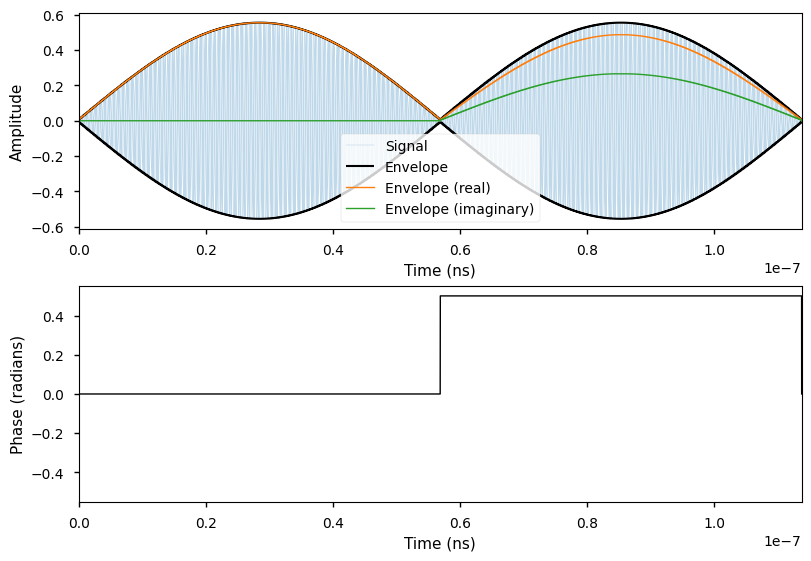

In [5]:
fig = plot_signal(schedules[5], dt, "d0", qubit_frequency, 2*duration*dt)


In [6]:
solutions = {}
for schedule in schedules:
    solution = solver.solve(
        run_input=schedule, steps=100, shots=1024,
        method="jax_odeint", atol=1e-6, rtol=1e-8, hmax=dt
    )
    solutions[schedule.name] = solution


In [7]:
solution = solutions[schedules[-1].name]
print(solution.iq_data[-1][-1])


[[-0.39172144  0.71931474]]


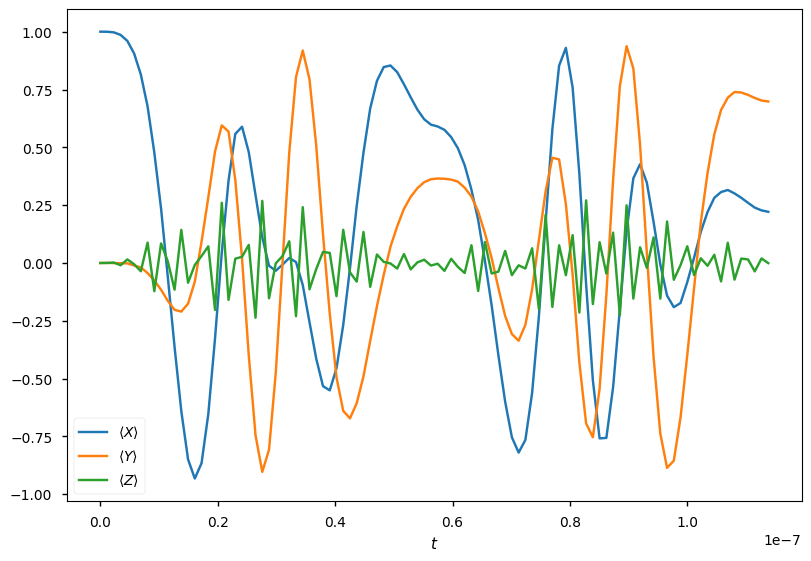

In [8]:
solution.plot_trajectory()


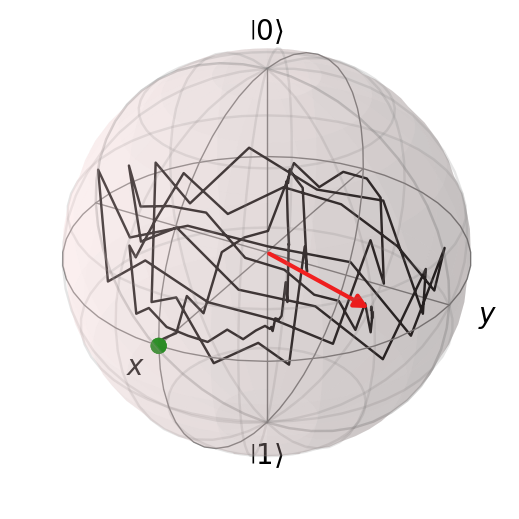

In [9]:
solution.plot_bloch_trajectory()


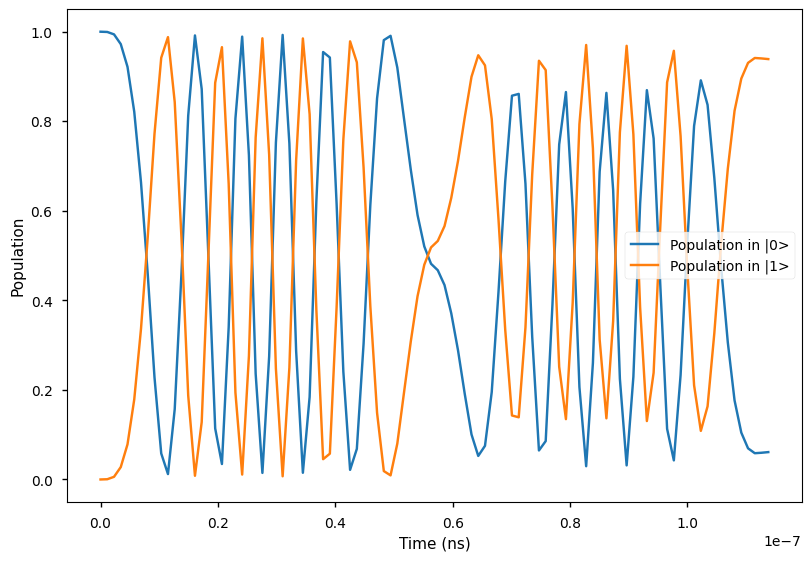

In [10]:
solution.plot_population()


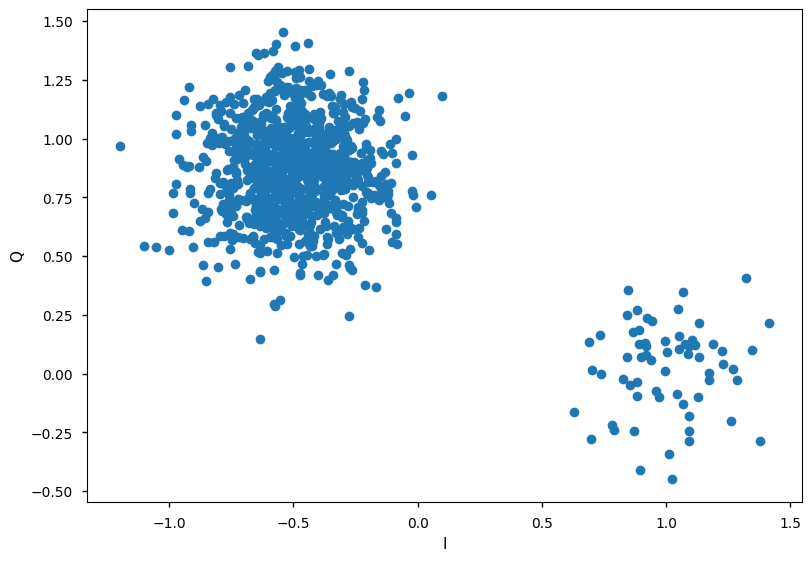

In [11]:
solution.plot_iq()


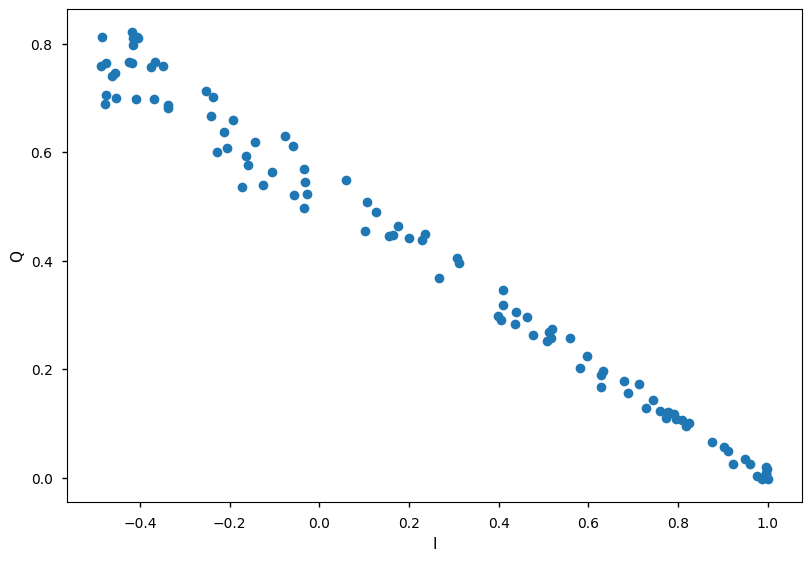

In [12]:
solution.plot_iq_trajectory()
